In [12]:
cor1[1].shape[0]

11

In [50]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from scipy.io import loadmat


# replace images and corners with those of matrix and warrior
imgids = ["dino"]#, "matrix", "warrior"]
for imgid in imgids:
    I1 = imread("./p4/"+imgid+"/"+imgid+"0.png")
    I2 = imread("./p4/"+imgid+"/"+imgid+"1.png")

    cor1 = np.load("./p4/"+imgid+"/cor1.npy")
    cor2 = np.load("./p4/"+imgid+"/cor2.npy")
    #plot_epipolar_lines(I1,I2,cor1,cor2)
    

def compute_fundamental(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] 

        Returns:
        Fundamental Matrix (3x3)

    """
    
    """
    Your code here
    """
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    #return your F matrix
    x = x1[0]
    y = x1[1]
    xp = x2[0]
    yp = x2[1]
    
    
    for i in range(x.shape[0]):
        if i == 0:
            data_mat = np.array([[x[i]*xp[i],\
                                 xp[i]*y[i],\
                                 xp[i],     \
                                 yp[i]*x[i],\
                                 yp[i]*y[i],\
                                 yp[i],     \
                                 x[i],      \
                                 y[i],      \
                                 1]])
            
        else:
            next_row = np.array([[x[i]*xp[i],\
                                   xp[i]*y[i],\
                                   xp[i],     \
                                   yp[i]*x[i],\
                                   yp[i]*y[i],\
                                   yp[i],     \
                                   x[i],      \
                                   y[i],      \
                                   1]])
            
            data_mat = np.vstack((data_mat,next_row))
    
    #print(data_mat.shape)
    # solve for f
    b = -1*np.ones((x.shape[0],1))
    
#     if x.shape[0] > 8:  
        
#         #use least squares
#         F_inv = np.linalg.pinv(data_mat)
#         F = F_inv@b
#     else:

    # http://www.cs.cmu.edu/~16385/s17/Slides/12.4_8Point_Algorithm.pdf
    
    #print(A.shape)
    #print(u.shape,s.shape,vh.shape)
    #print(V.shape)
    #print(F.shape)
    #print(F)
    #print(u.shape,S.shape,vh.shape)
    
    A = data_mat.T@data_mat
    u,s,vh = np.linalg.svd(A,full_matrices = False)
    V = vh.T
    F = V[:,-1]
    F = F.reshape((3,3))
    Fu,Fs,Fvh = np.linalg.svd(F)
    S = np.diag(Fs)
    S[2,2] = 0
    Fnew = Fu@S@Fvh
    F = Fnew
        
        
    #print(F)
    #F = F.reshape((3,3))
    #F should be rank 2
    #print(F)
#     u,s,vh = np.linalg.svd(F,full_matrices = True)
#     S = np.diag(s)
#     S[2,2] = 0
#     print(u,S,vh)
#     F = u@S@vh
    
    return F


def fundamental_matrix(x1,x2):
    # Normalization of the corner points is handled here
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]

In [51]:
# check my work
F = fundamental_matrix(cor1,cor2)

In [30]:
cor1[0].shape

(13,)

In [31]:
x = cor1[0][0]
y = cor1[1][0]
xp = cor2[0][0]
yp = cor2[1][0]

In [32]:
np.linalg.norm(F)

1.0000212229809082

In [33]:
p = np.array([[x],[y],[1]])
pp = np.array([[xp],[yp],[1]])
pp.T@F@p

array([[0.28158111]])

In [52]:
def compute_epipole(F):
    '''
    This function computes the epipoles for a given fundamental matrix 
    and corner point correspondences
    input:
    F--> Fundamental matrix
    output:
    e1--> corresponding epipole in image 1
    e2--> epipole in image2
    '''
    _,_,Vt = np.linalg.svd(F)
    e2     = Vt.T[:,-1]/Vt.T[-1,-1]
#     do epipoles need to be homogenized - yes they do
    _,_,Vt = np.linalg.svd(F.T)
    e1     = Vt.T[:,-1]/Vt.T[-1,-1]
    return e1,e2

In [60]:
e1,e2 = compute_epipole(F)


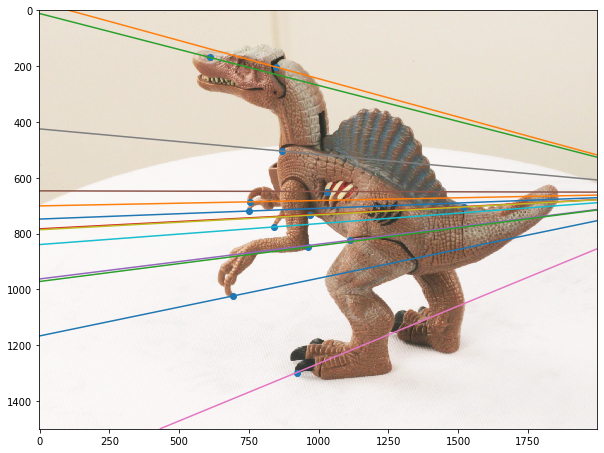

In [59]:
plot_epipolar_lines(I1,I2,cor1,cor2)


In [56]:
def plot_epipolar_lines(img1,img2, cor1, cor2):
    """Plot epipolar lines on image given image, corners

    Args:
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)

    """
        
    """
    Your code here:
    """
    F = fundamental_matrix(cor1,cor2)
    e1,e2 = compute_epipole(F)
    
    
    plt.figure(figsize = (10,10))
    plt.imshow(img1)
    plt.scatter(cor1[0,:],cor1[1,:])
    
    for i in range(cor1[0].shape[0]):
        
        x_vec = np.array([cor1[0][i],cor1[1][i]])
        
        m = (x_vec[1]-e1[1])/(x_vec[0]-e1[0])
        b = x_vec[1]-m*x_vec[0]
        
        x_line = []
        y_line = []
        for j in range(img1.shape[1]):
            y = m*j+b
            y_max  = img1.shape[0]
            if y>0 and y<y_max-1:
                x_line.append(j)
                y_line.append(y)
        plt.plot(x_line,y_line)
    plt.show()
    
    
    
    
#     #calculate the equation for each epipolar line
#     for i in range(cor1[0].shape[0]):
        
#         #datapoint
#         x_vec = np.array([cor1[0][i],cor1[1][i],1])
#         lp = F@x_vec
#         # gives ax+by+c
#         #y = - (ax+c)/b
        
#         x_line = []
#         y_line = []
#         y_max  = img1.shape[0]
#         for j in range(img1.shape[1]):
#             y = -(lp[0]*j+lp[2])/lp[1]
#             if y>0 and y<y_max:
#                 x_line.append(j)
#                 y_line.append(y)
    

#         plt.plot(x_line,y_line)
#     plt.show()



    
    
            